**Project Title**

AI-Powered Disaster Response Logistics: Optimized Emergency Supply Chain Routing

**Problem Statement**

Disasters such as floods, cyclones, earthquakes, and wildfires frequently disrupt road networks, making it challenging to deliver essential supplies, including food, water, and medicine, to affected communities. Traditional supply chain routing methods are slow and ineffective under uncertain and dynamic conditions, leading to delays, resource wastage, and unmet demand. An intelligent system that can adapt to changing road conditions and demand patterns is essential for improving disaster response efficiency and saving lives.

**Description**

This project develops an AI-driven optimization model for emergency supply chain routing during disasters. The system integrates road network data, hazard impact information, and demand signals from affected shelters to generate optimized delivery routes. It uses a combination of graph optimization techniques and reinforcement learning to dynamically re-route vehicles when roads are blocked or new requests arise.

The dataset may include:

Road network graphs (OpenStreetMap, government GIS data)

Disaster impact data (flood zones, landslide risks, road closures)

Demand data (shelter locations, population size, priority needs)

Logistics data (vehicle capacities, depot locations, delivery times)

The AI model predicts optimal routes that minimize delays, balance demand fulfillment across shelters, and reduce operational costs while avoiding hazardous zones. A visualization dashboard will display live routes, supply demand status, and risk zones to support decision-making for emergency response teams.

In [2]:
%pip install folium osmnx
import pandas as pd
import geopandas as gpd
import osmnx as ox
import folium
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 6.8 MB/s eta 0:00:00


In [3]:
# Load Shelter Demand Data

shelters = pd.read_csv("/content/mumbai_shelters_large.csv")
print("🏠 Shelter Data Preview:\n", shelters.head(), "\n")
print("Shelter Data Info:")
print(shelters.info(), "\n")
print("Shelter Data Description:")
print(shelters.describe(), "\n")
print("Missing Values in Shelter Data:\n", shelters.isnull().sum(), "\n")

🏠 Shelter Data Preview:
    shelter_id   latitude  longitude  capacity district
0           1  18.987270  72.768089      1128   Mumbai
1           2  19.275357  72.935974      1589   Mumbai
2           3  19.165997  72.939222       703   Mumbai
3           4  19.099329  72.973100       781   Mumbai
4           5  18.878009  73.004132      1952   Mumbai 

Shelter Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   shelter_id  300 non-null    int64  
 1   latitude    300 non-null    float64
 2   longitude   300 non-null    float64
 3   capacity    300 non-null    int64  
 4   district    300 non-null    object 
dtypes: float64(2), int64(2), object(1)
memory usage: 11.8+ KB
None 

Shelter Data Description:
       shelter_id    latitude   longitude     capacity
count  300.000000  300.000000  300.000000   300.000000
mean   150.500000   19.0476

In [4]:

# Load Vehicle / Depot Data

vehicles = pd.read_csv("/content/mumbai_vehicles_large.csv")
print("🚚 Vehicle Data Preview:\n", vehicles.head(), "\n")
print("Vehicle Data Info:")
print(vehicles.info(), "\n")
print("Vehicle Data Description:")
print(vehicles.describe(), "\n")
print("Missing Values in Vehicle Data:\n", vehicles.isnull().sum(), "\n")

🚚 Vehicle Data Preview:
   vehicle_id       type  capacity   agency     status district   latitude  \
0         V1       Jeep        66  Private  Available   Mumbai  19.221906   
1         V2  Ambulance        20     Govt     In Use   Mumbai  19.030165   
2         V3  Ambulance        10      NGO     In Use   Mumbai  18.908794   
3         V4  Ambulance        28     Govt  Available   Mumbai  18.866889   
4         V5      Truck        35  Private  Available   Mumbai  19.276654   

   longitude  
0  72.935337  
1  72.844102  
2  72.757363  
3  73.002994  
4  72.761370   

Vehicle Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   vehicle_id  1000 non-null   object 
 1   type        1000 non-null   object 
 2   capacity    1000 non-null   int64  
 3   agency      1000 non-null   object 
 4   status      1000 non-null   object 
 5   dist

In [5]:

# Load Disaster Impact Data (Hazard Zones)

hazard_zones = pd.read_csv("/content/mumbai_hazard_zones_large.csv")
print("🌊 Hazard Zones Data Preview:\n", hazard_zones.head(), "\n")
print("Hazard Zones Info:")
print(hazard_zones.info(), "\n")
print("Hazard Zones Description:")
print(hazard_zones.describe(), "\n")
print("Missing Values in Hazard Zones:\n", hazard_zones.isnull().sum(), "\n")

🌊 Hazard Zones Data Preview:
   zone_id   latitude  longitude risk_level hazard_type
0     HZ1  18.902272  72.932882        Low        Fire
1     HZ2  19.157032  73.006295       High       Flood
2     HZ3  19.046991  72.751171     Medium        Fire
3     HZ4  19.177318  72.913559     Medium     Cyclone
4     HZ5  18.851458  72.853951     Medium        Fire 

Hazard Zones Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   zone_id      300 non-null    object 
 1   latitude     300 non-null    float64
 2   longitude    300 non-null    float64
 3   risk_level   300 non-null    object 
 4   hazard_type  300 non-null    object 
dtypes: float64(2), object(3)
memory usage: 11.8+ KB
None 

Hazard Zones Description:
         latitude   longitude
count  300.000000  300.000000
mean    19.054355   72.930491
std      0.139788    0.104787
min     18.8001

In [6]:
#  Load Road Network for Mumbai

place = "Mumbai, India"
G = ox.graph_from_place(place, network_type="drive")

# Convert to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

# Save as CSV
nodes.to_csv("mumbai_roads_nodes.csv", index=False)
edges.to_csv("mumbai_roads_edges.csv", index=False)

print(f"✅ Road network loaded: {len(G.nodes)} nodes, {len(G.edges)} edges")
print("📂 Files saved: mumbai_roads_nodes.csv & mumbai_roads_edges.csv\n")

# Download files in Colab
#files.download("mumbai_roads_nodes.csv")
#files.download("mumbai_roads_edges.csv")


✅ Road network loaded: 25367 nodes, 58059 edges
📂 Files saved: mumbai_roads_nodes.csv & mumbai_roads_edges.csv



In [7]:
# Load roads_edges

roads_edges = pd.read_csv("/content/mumbai_roads_edges.csv")
print("roads_edges Data Preview:\n", roads_edges.head(), "\n")
print("roads_edges Info:")
print(roads_edges.info(), "\n")
print("roads_edges Description:")
print(roads_edges.describe(), "\n")
print("Missing Values in roads_edges:\n", roads_edges.isnull().sum(), "\n")

roads_edges Data Preview:
                                 osmid      highway lanes  \
0               [122277872, 84017620]     motorway     5   
1  [779575745, 779575746, 1188911679]  residential   NaN   
2                            38756487    secondary   NaN   
3                            39492674    secondary   NaN   
4                          1165552351     tertiary   NaN   

                                     name  oneway reversed       length  \
0                     Sion Panvel Highway    True    False  2053.419145   
1                                     NaN   False     True   547.410950   
2  Nanabhai Moos Marg (Upper Colaba Road)   False    False     4.698765   
3                             Bakery Lane   False     True   159.726483   
4                      Nanabhai Moos Marg   False    False   131.937496   

  maxspeed                                           geometry tunnel junction  \
0      120  LINESTRING (72.9591875 19.0588477, 72.958572 1...    NaN      NaN   

In [8]:
# Load roads_nodes

roads_nodes = pd.read_csv("/content/mumbai_roads_nodes.csv")
print("roads_nodes Data Preview:\n", roads_nodes.head(), "\n")
print("roads_nodes Info:")
print(roads_nodes.info(), "\n")
print("roads_nodes Description:")
print(roads_nodes.describe(), "\n")
print("Missing Values in roads_nodes:\n", roads_nodes.isnull().sum(), "\n")

roads_nodes Data Preview:
            y          x  street_count highway junction railway  \
0  19.058848  72.959187             3     NaN      NaN     NaN   
1  18.906005  72.816399             3     NaN      NaN     NaN   
2  18.906823  72.816752             3     NaN      NaN     NaN   
3  18.911485  72.823269             1     NaN      NaN     NaN   
4  18.911176  72.820864             3     NaN      NaN     NaN   

                        geometry  
0  POINT (72.9591875 19.0588477)  
1  POINT (72.8163986 18.9060052)  
2   POINT (72.816752 18.9068234)  
3  POINT (72.8232687 18.9114846)  
4  POINT (72.8208639 18.9111765)   

roads_nodes Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25367 entries, 0 to 25366
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y             25367 non-null  float64
 1   x             25367 non-null  float64
 2   street_count  25367 non-null  int64  
 3   highway       1578

In [9]:
# Load roads_edges Data
print("roads_edges Data Preview:\n", roads_edges.head(), "\n")
print("roads_edges Info:")
print(roads_edges.info(), "\n")
print("roads_edges Description:")
print(roads_edges.describe(), "\n")
print("Missing Values in roads_edges:\n", roads_edges.isnull().sum(), "\n")

roads_edges Data Preview:
                                 osmid      highway lanes  \
0               [122277872, 84017620]     motorway     5   
1  [779575745, 779575746, 1188911679]  residential   NaN   
2                            38756487    secondary   NaN   
3                            39492674    secondary   NaN   
4                          1165552351     tertiary   NaN   

                                     name  oneway reversed       length  \
0                     Sion Panvel Highway    True    False  2053.419145   
1                                     NaN   False     True   547.410950   
2  Nanabhai Moos Marg (Upper Colaba Road)   False    False     4.698765   
3                             Bakery Lane   False     True   159.726483   
4                      Nanabhai Moos Marg   False    False   131.937496   

  maxspeed                                           geometry tunnel junction  \
0      120  LINESTRING (72.9591875 19.0588477, 72.958572 1...    NaN      NaN   

In [10]:
# Load roads_nodes Data
print("roads_nodes Data Preview:\n", roads_nodes.head(), "\n")
print("roads_nodes Info:")
print(roads_nodes.info(), "\n")
print("roads_nodes Description:")
print(roads_nodes.describe(), "\n")
print("Missing Values in roads_nodes:\n", roads_nodes.isnull().sum(), "\n")

roads_nodes Data Preview:
            y          x  street_count highway junction railway  \
0  19.058848  72.959187             3     NaN      NaN     NaN   
1  18.906005  72.816399             3     NaN      NaN     NaN   
2  18.906823  72.816752             3     NaN      NaN     NaN   
3  18.911485  72.823269             1     NaN      NaN     NaN   
4  18.911176  72.820864             3     NaN      NaN     NaN   

                        geometry  
0  POINT (72.9591875 19.0588477)  
1  POINT (72.8163986 18.9060052)  
2   POINT (72.816752 18.9068234)  
3  POINT (72.8232687 18.9114846)  
4  POINT (72.8208639 18.9111765)   

roads_nodes Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25367 entries, 0 to 25366
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y             25367 non-null  float64
 1   x             25367 non-null  float64
 2   street_count  25367 non-null  int64  
 3   highway       1578

In [11]:
# Create a base map centered around Mumbai
m = folium.Map(location=[19.0760, 72.8777], zoom_start=11)

# Add markers for shelters
for idx, row in shelters.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Shelter ID: {row['shelter_id']}<br>Capacity: {row['capacity']}",
        icon=folium.Icon(color='blue', icon='home')
    ).add_to(m)

# Add markers for available vehicles
for idx, row in vehicles[vehicles['status'] == 'Available'].iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Vehicle ID: {row['vehicle_id']}<br>Type: {row['type']}<br>Capacity: {row['capacity']}",
        icon=folium.Icon(color='green', icon='car')
    ).add_to(m)

# Add markers for hazard zones with different colors based on risk level
color_map = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
for idx, row in hazard_zones.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Hazard Zone ID: {row['zone_id']}<br>Risk Level: {row['risk_level']}<br>Type: {row['hazard_type']}",
        icon=folium.Icon(color=color_map.get(row['risk_level'], 'gray'), icon='warning')
    ).add_to(m)

# Display the map
m

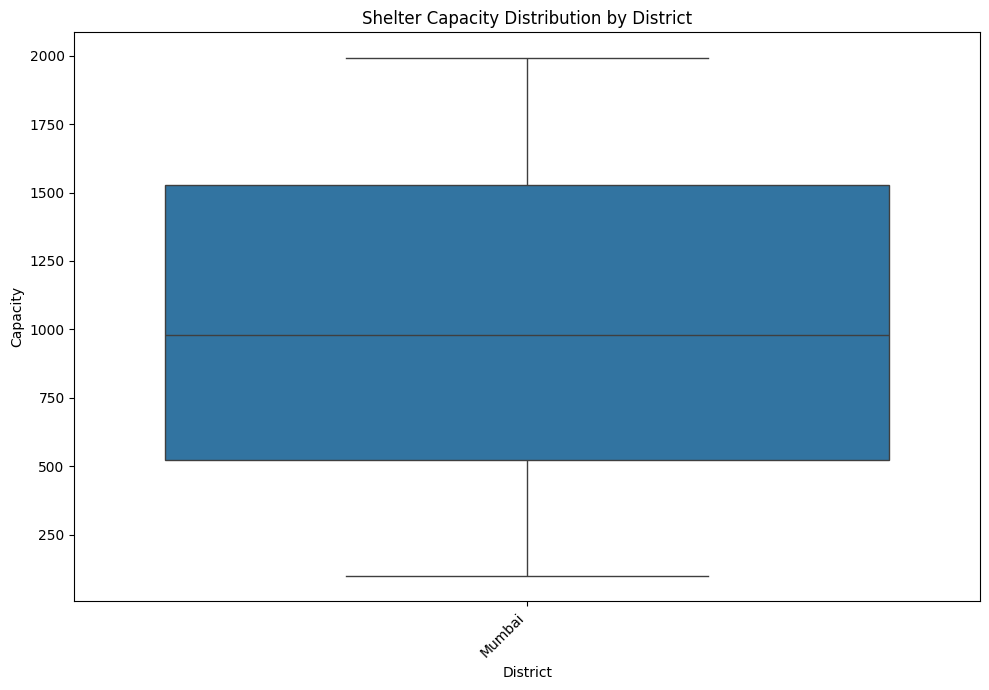

In [12]:
# Bivariate Analysis: Shelter Capacity vs. District

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.boxplot(data=shelters, x='district', y='capacity')
plt.title('Shelter Capacity Distribution by District')
plt.xlabel('District')
plt.ylabel('Capacity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

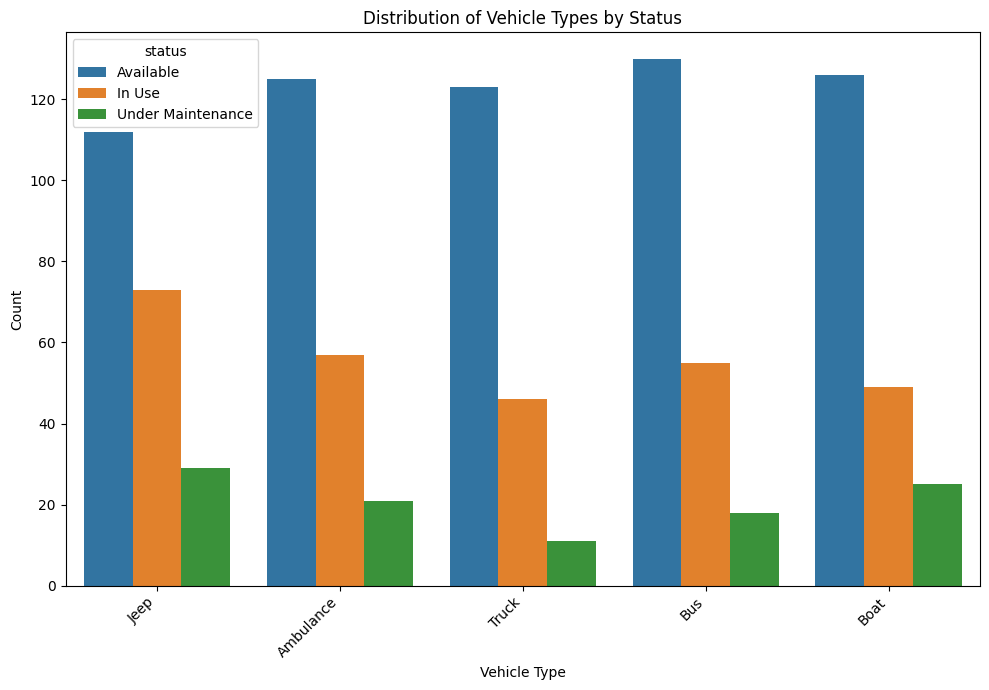


Cross-tabulation of Vehicle Type and Status:



status     Available  In Use  Under Maintenance
type                                           
Ambulance        125      57                 21
Boat             126      49                 25
Bus              130      55                 18
Jeep             112      73                 29
Truck            123      46                 11

In [13]:
# Bivariate Analysis: Vehicle Type vs. Status

plt.figure(figsize=(10, 7))
sns.countplot(data=vehicles, x='type', hue='status')
plt.title('Distribution of Vehicle Types by Status')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# You can also look at this relationship using a cross-tabulation
print("\nCross-tabulation of Vehicle Type and Status:\n")
display(pd.crosstab(vehicles['type'], vehicles['status']))

In [14]:
# Convert hazard_zones DataFrame to GeoDataFrame
hazard_zones_gdf = gpd.GeoDataFrame(
    hazard_zones, geometry=gpd.points_from_xy(hazard_zones.longitude, hazard_zones.latitude), crs="EPSG:4326"
)

print("Hazard Zones GeoDataFrame Preview:\n", hazard_zones_gdf.head(), "\n")
print("Hazard Zones GeoDataFrame Info:")
print(hazard_zones_gdf.info(), "\n")

Hazard Zones GeoDataFrame Preview:
   zone_id   latitude  longitude risk_level hazard_type  \
0     HZ1  18.902272  72.932882        Low        Fire   
1     HZ2  19.157032  73.006295       High       Flood   
2     HZ3  19.046991  72.751171     Medium        Fire   
3     HZ4  19.177318  72.913559     Medium     Cyclone   
4     HZ5  18.851458  72.853951     Medium        Fire   

                    geometry  
0  POINT (72.93288 18.90227)  
1   POINT (73.0063 19.15703)  
2  POINT (72.75117 19.04699)  
3  POINT (72.91356 19.17732)  
4  POINT (72.85395 18.85146)   

Hazard Zones GeoDataFrame Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   zone_id      300 non-null    object  
 1   latitude     300 non-null    float64 
 2   longitude    300 non-null    float64 
 3   risk_level   300 non-null    object  
 4   hazard_type  300 non

In [15]:
import geopandas as gpd
from shapely.geometry import Point

# --- Convert Shelters and Vehicles into GeoDataFrames ---
shelters_gdf = gpd.GeoDataFrame(
    shelters, geometry=gpd.points_from_xy(shelters.longitude, shelters.latitude), crs="EPSG:4326"
)

vehicles_gdf = gpd.GeoDataFrame(
    vehicles, geometry=gpd.points_from_xy(vehicles.longitude, vehicles.latitude), crs="EPSG:4326"
)

# --- Filter only High-risk hazard zones ---
high_risk_zones = hazard_zones_gdf[hazard_zones_gdf['risk_level'] == 'High']

# --- Spatial join: find shelters within High-risk hazard zones ---
shelters_in_high_risk = gpd.sjoin(shelters_gdf, high_risk_zones, how="inner", predicate="within")

# --- Spatial join: find vehicles within High-risk hazard zones ---
vehicles_in_high_risk = gpd.sjoin(vehicles_gdf, high_risk_zones, how="inner", predicate="within")

print("🚨 Shelters in High-risk zones:", len(shelters_in_high_risk))
print(shelters_in_high_risk[['shelter_id', 'capacity', 'district', 'hazard_type']].head(), "\n")

print("🚨 Vehicles in High-risk zones:", len(vehicles_in_high_risk))
print(vehicles_in_high_risk[['vehicle_id', 'type', 'status', 'hazard_type']].head(), "\n")


🚨 Shelters in High-risk zones: 0
Empty DataFrame
Columns: [shelter_id, capacity, district, hazard_type]
Index: [] 

🚨 Vehicles in High-risk zones: 0
Empty DataFrame
Columns: [vehicle_id, type, status, hazard_type]
Index: [] 



In [16]:
# Create a base map centered on Mumbai
m = folium.Map(location=[19.0760, 72.8777], zoom_start=11)

# --- Plot Shelters ---
for idx, row in shelters.iterrows():
    if row['shelter_id'] in shelters_in_high_risk['shelter_id'].values:
        # High-risk shelter
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"🚨 HIGH-RISK Shelter<br>ID: {row['shelter_id']}<br>Capacity: {row['capacity']}",
            icon=folium.Icon(color='red', icon='home')
        ).add_to(m)
    else:
        # Safe shelter
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Shelter ID: {row['shelter_id']}<br>Capacity: {row['capacity']}",
            icon=folium.Icon(color='blue', icon='home')
        ).add_to(m)

# --- Plot Vehicles ---
for idx, row in vehicles.iterrows():
    if row['vehicle_id'] in vehicles_in_high_risk['vehicle_id'].values:
        # High-risk vehicle
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"🚨 HIGH-RISK Vehicle<br>ID: {row['vehicle_id']}<br>Type: {row['type']}<br>Status: {row['status']}",
            icon=folium.Icon(color='darkred', icon='car')
        ).add_to(m)
    else:
        # Safe vehicle
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Vehicle ID: {row['vehicle_id']}<br>Type: {row['type']}<br>Status: {row['status']}",
            icon=folium.Icon(color='green', icon='car')
        ).add_to(m)

# --- Plot Hazard Zones ---
color_map = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
for idx, row in hazard_zones.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Hazard Zone ID: {row['zone_id']}<br>Risk Level: {row['risk_level']}<br>Type: {row['hazard_type']}",
        icon=folium.Icon(color=color_map.get(row['risk_level'], 'gray'), icon='warning')
    ).add_to(m)

# Show map
m


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming the goal is to predict 'risk_level' based on shelter and vehicle data.
# We'll need to combine relevant data and encode categorical features.

# Let's create a simplified dataset for classification
# We'll use shelter capacity and location as features, and risk level of nearest hazard zone as target

# Combine shelters and hazard zones data based on spatial proximity
# First, ensure both GeoDataFrames are in the same CRS
hazard_zones_gdf = hazard_zones_gdf.to_crs(shelters_gdf.crs)

# Find the nearest hazard zone to each shelter
from shapely.geometry import Point
from scipy.spatial import distance

def nearest_hazard_zone(shelter_point, hazard_zones_gdf):
    min_dist = float('inf')
    nearest_zone = None
    for idx, zone in hazard_zones_gdf.iterrows():
        dist = shelter_point.distance(zone.geometry)
        if dist < min_dist:
            min_dist = dist
            nearest_zone = zone
    return nearest_zone['risk_level'] if nearest_zone is not None else None

# Apply the function to find the nearest hazard zone risk level for each shelter
shelters['nearest_hazard_risk'] = shelters_gdf.geometry.apply(lambda x: nearest_hazard_zone(x, hazard_zones_gdf))

# Drop rows where nearest_hazard_risk is None (if any)
shelters.dropna(subset=['nearest_hazard_risk'], inplace=True)

# Prepare data for classification
# Features: latitude, longitude, capacity
X = shelters[['latitude', 'longitude', 'capacity']]
# Target: nearest_hazard_risk (encode categorical variable)
y = shelters['nearest_hazard_risk']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Results:")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Random Forest Classifier Results:

Confusion Matrix:
 [[14  4  8]
 [ 8  5 11]
 [13  6 21]]

Classification Report:
               precision    recall  f1-score   support

        High       0.40      0.54      0.46        26
         Low       0.33      0.21      0.26        24
      Medium       0.53      0.53      0.53        40

    accuracy                           0.44        90
   macro avg       0.42      0.42      0.41        90
weighted avg       0.44      0.44      0.43        90



In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the Logistic Regression Classifier
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_classifier.predict(X_test)

# Evaluate the model
print("Logistic Regression Classifier Results:")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, target_names=le.classes_))

Logistic Regression Classifier Results:

Confusion Matrix:
 [[ 1  0 25]
 [ 2  0 22]
 [ 4  0 36]]

Classification Report:
               precision    recall  f1-score   support

        High       0.14      0.04      0.06        26
         Low       0.00      0.00      0.00        24
      Medium       0.43      0.90      0.59        40

    accuracy                           0.41        90
   macro avg       0.19      0.31      0.22        90
weighted avg       0.23      0.41      0.28        90



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


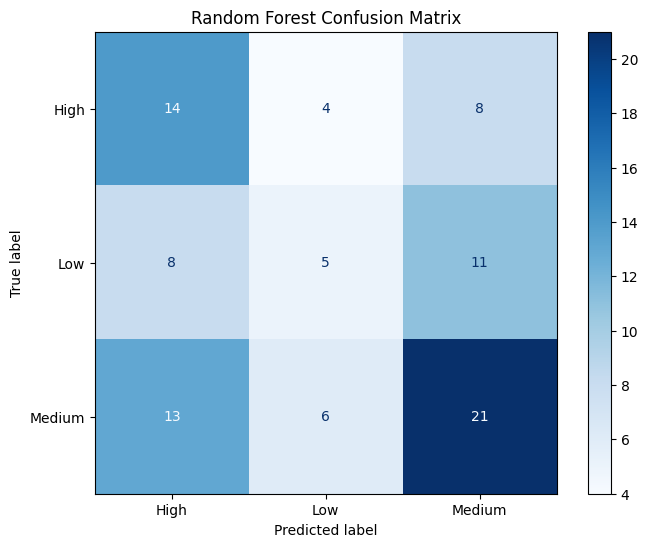

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the confusion matrix for the Random Forest model
cm_rf = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best_rf = best_rf_model.predict(X_test)
print("\nEvaluation of the best Random Forest model on the test set:")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf, target_names=le.classes_))

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best accuracy score:  0.5619047619047619

Evaluation of the best Random Forest model on the test set:

Confusion Matrix:
 [[15  3  8]
 [ 8  5 11]
 [12  7 21]]

Classification Report:
               precision    recall  f1-score   support

        High       0.43      0.58      0.49        26
         Low       0.33      0.21      0.26        24
      Medium       0.53      0.53      0.53        40

    accuracy                           0.46        90
   macro avg       0.43      0.44      0.42        90
weighted avg       0.45      0.46      0.44        90



In [21]:
# Create a copy of the dataset with the encoded target variable
shelters_encoded = X.copy()
shelters_encoded['nearest_hazard_risk_encoded'] = y_encoded

print("Dataset with encoded target variable preview:")
display(shelters_encoded.head())

Dataset with encoded target variable preview:


latitude  longitude  capacity  nearest_hazard_risk_encoded
0  18.987270  72.768089      1128                            1
1  19.275357  72.935974      1589                            1
2  19.165997  72.939222       703                            0
3  19.099329  72.973100       781                            2
4  18.878009  73.004132      1952                            1

In [22]:
# Compute the correlation matrix
correlation_matrix = shelters_encoded.corr()

# Display the correlation matrix
print("Correlation Matrix:")
display(correlation_matrix)

Correlation Matrix:


latitude  longitude  capacity  \
latitude                     1.000000  -0.101367  0.007680   
longitude                   -0.101367   1.000000  0.120961   
capacity                     0.007680   0.120961  1.000000   
nearest_hazard_risk_encoded -0.018932   0.125427 -0.048215   

                             nearest_hazard_risk_encoded  
latitude                                       -0.018932  
longitude                                       0.125427  
capacity                                       -0.048215  
nearest_hazard_risk_encoded                     1.000000

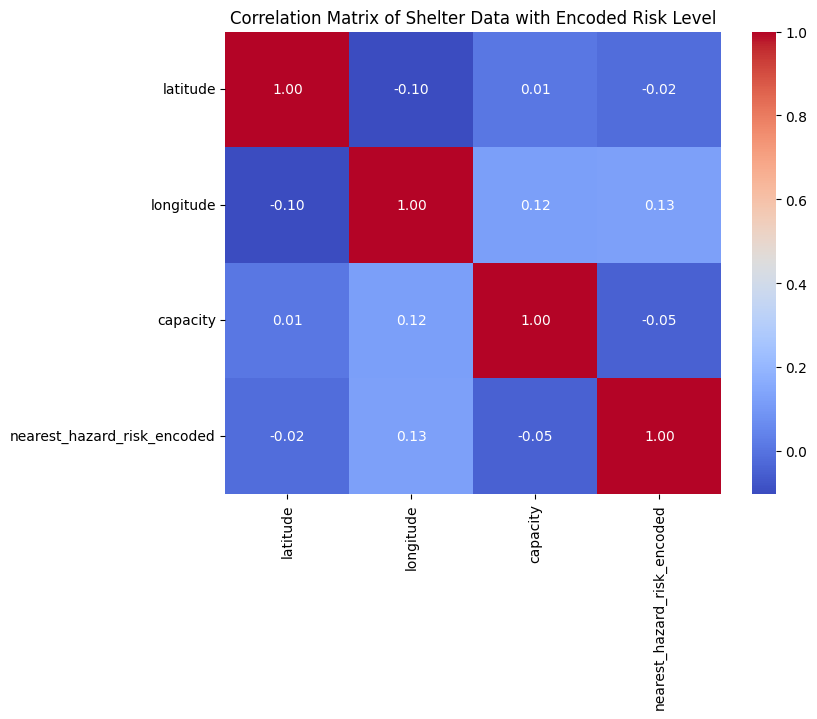

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Shelter Data with Encoded Risk Level')
plt.show()

In [24]:
import joblib

# Save the best Random Forest model
filename = 'best_random_forest_model.joblib'
joblib.dump(best_rf_model, filename)

print(f"Best Random Forest model saved as {filename}")

Best Random Forest model saved as best_random_forest_model.joblib


In [25]:
from sklearn.preprocessing import StandardScaler
import joblib

# Initialize and fit the scaler on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# You can also transform the test data
X_test_scaled = scaler.transform(X_test)

# Save the fitted scaler
scaler_filename = 'scaler.joblib'
joblib.dump(scaler, scaler_filename)

print(f"Scaler fitted and saved as {scaler_filename}")

Scaler fitted and saved as scaler.joblib


In [26]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# Load the trained Random Forest model and the scaler
try:
    best_rf_model = joblib.load('best_random_forest_model.joblib')
    scaler = joblib.load('scaler.joblib')
    # Assuming 'le' (LabelEncoder) was also saved or can be recreated
    # If not saved, you might need to fit it again on the unique risk levels
    # For demonstration, let's assume you have the classes available or saved the encoder
    # If you saved the encoder, load it here:
    # le = joblib.load('label_encoder.joblib')
    # If not saved and you know the classes:
    le = LabelEncoder()
    le.fit(['High', 'Low', 'Medium']) # Fit with your actual classes

except FileNotFoundError:
    st.error("Model or scaler file not found. Please ensure 'best_random_forest_model.joblib', 'scaler.joblib', and 'label_encoder.joblib' (if saved) are in the same directory.")
    st.stop()


st.title("Disaster Response Shelter Risk Prediction")

st.write("Enter the shelter's location and capacity to predict its hazard risk level.")

# Input fields for shelter data
latitude = st.number_input("Latitude", value=19.0)
longitude = st.number_input("Longitude", value=72.9)
capacity = st.number_input("Capacity", value=500)

# Create a DataFrame from the input data
input_data = pd.DataFrame([[latitude, longitude, capacity]], columns=['latitude', 'longitude', 'capacity'])

# Scale the input data
input_data_scaled = scaler.transform(input_data)

# Make a prediction
predicted_risk_encoded = best_rf_model.predict(input_data_scaled)

# Decode the predicted risk level
predicted_risk = le.inverse_transform(predicted_risk_encoded)

st.subheader("Predicted Hazard Risk Level:")
st.write(predicted_risk[0])

st.write("Note: This is a simplified example and the prediction is based on the trained Random Forest model.")

Writing app.py


# Task
Develop a Streamlit application that predicts disaster response and logistics response paths using a trained model, incorporating road network data and hazard information.

## Load and prepare road network data

### Subtask:
Load the road network data and convert it into a suitable format for graph-based routing.


**Reasoning**:
Import necessary libraries and load the road network data from the saved CSV files into pandas DataFrames.



In [27]:
import networkx as nx

roads_nodes = pd.read_csv("mumbai_roads_nodes.csv")
roads_edges = pd.read_csv("mumbai_roads_edges.csv")

print("Roads Nodes Loaded:")
display(roads_nodes.head())
print("\nRoads Edges Loaded:")
display(roads_edges.head())

Roads Nodes Loaded:


y          x  street_count highway junction railway  \
0  19.058848  72.959187             3     NaN      NaN     NaN   
1  18.906005  72.816399             3     NaN      NaN     NaN   
2  18.906823  72.816752             3     NaN      NaN     NaN   
3  18.911485  72.823269             1     NaN      NaN     NaN   
4  18.911176  72.820864             3     NaN      NaN     NaN   

                        geometry  
0  POINT (72.9591875 19.0588477)  
1  POINT (72.8163986 18.9060052)  
2   POINT (72.816752 18.9068234)  
3  POINT (72.8232687 18.9114846)  
4  POINT (72.8208639 18.9111765)


Roads Edges Loaded:


osmid      highway lanes  \
0               [122277872, 84017620]     motorway     5   
1  [779575745, 779575746, 1188911679]  residential   NaN   
2                            38756487    secondary   NaN   
3                            39492674    secondary   NaN   
4                          1165552351     tertiary   NaN   

                                     name  oneway reversed       length  \
0                     Sion Panvel Highway    True    False  2053.419145   
1                                     NaN   False     True   547.410950   
2  Nanabhai Moos Marg (Upper Colaba Road)   False    False     4.698765   
3                             Bakery Lane   False     True   159.726483   
4                      Nanabhai Moos Marg   False    False   131.937496   

  maxspeed                                           geometry tunnel junction  \
0      120  LINESTRING (72.9591875 19.0588477, 72.958572 1...    NaN      NaN   
1      NaN  LINESTRING (72.9591875 19.0588477, 72.9594013 ...    yes      NaN   
2       50  LINESTRING (72.8163986 18.9060052, 72.8164274 ...    NaN      NaN   
3       50  LINESTRING (72.8163986 18.9060052, 72.8161893 ...    NaN      NaN   
4      NaN  LINESTRING (72.8163986 18.9060052, 72.816224 1...    NaN      NaN   

  bridge access width  ref  
0    NaN    NaN   NaN  NaN  
1    NaN    NaN   NaN  NaN  
2    NaN    NaN   NaN  NaN  
3    NaN    NaN   NaN  NaN  
4    NaN    NaN   NaN  NaN

**Reasoning**:
Create a directed graph from the loaded road network data, adding nodes with their attributes and edges with their attributes, handling reversed edges.



In [32]:
G = nx.DiGraph()

# Add nodes with attributes
# Convert geometry strings to Point objects for easier comparison
roads_nodes['geometry_point'] = roads_nodes['geometry'].apply(lambda x: Point(float(x.split('(')[1].split(' ')[0]), float(x.split(' ')[1].split(')')[0])))

for index, row in roads_nodes.iterrows():
    G.add_node(index, x=row['x'], y=row['y'], geometry=row['geometry_point'])

# Add edges with attributes
for index, row in roads_edges.iterrows():
    try:
        # Extract start and end coordinates from the 'geometry' string
        coords = row['geometry'].replace('LINESTRING (', '').replace(')', '').split(', ')
        start_coords_str = coords[0]
        end_coords_str = coords[-1]

        # Convert coordinates to Point objects
        start_point = Point(float(start_coords_str.split(' ')[0]), float(start_coords_str.split(' ')[1]))
        end_point = Point(float(end_coords_str.split(' ')[0]), float(end_coords_str.split(' ')[1]))

        # Find the index of the start and end nodes in roads_nodes based on spatial proximity
        # Use a small tolerance for floating point comparisons
        u_index = roads_nodes[roads_nodes['geometry_point'].apply(lambda p: p.almost_equals(start_point, decimal=6))].index[0]
        v_index = roads_nodes[roads_nodes['geometry_point'].apply(lambda p: p.almost_equals(end_point, decimal=6))].index[0]


        attributes = row.drop(['osmid', 'geometry']).to_dict()

        # Handle reversed edges
        if row['reversed']:
            G.add_edge(v_index, u_index, key=row['osmid'], **attributes)
        else:
            G.add_edge(u_index, v_index, key=row['osmid'], **attributes)
    except IndexError:
        # Handle cases where start or end node is not found in roads_nodes
        print(f"Warning: Could not find start or end node for edge with osmid {row['osmid']}. Skipping edge.")
        continue


print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

ValueError: could not convert string to float: '(72.9591875'

**Reasoning**:
The previous attempt to create the graph failed because the geometry string parsing was incorrect and didn't match the format in the `roads_nodes` DataFrame. I will modify the code to correctly extract the start and end node indices from the 'geometry' column of the `roads_edges` DataFrame by matching the coordinates to the 'geometry' column of the `roads_nodes` DataFrame.



In [29]:
G = nx.DiGraph()

# Add nodes with attributes
for index, row in roads_nodes.iterrows():
    G.add_node(index, x=row['x'], y=row['y'])

# Add edges with attributes
for index, row in roads_edges.iterrows():
    try:
        # Extract start and end coordinates from the 'geometry' string
        coords = row['geometry'].replace('LINESTRING (', '').replace(')', '').split(', ')
        start_coords_str = coords[0]
        end_coords_str = coords[-1]

        # Find the index of the start and end nodes in roads_nodes based on coordinates
        u_index = roads_nodes.index[(roads_nodes['geometry'] == f'POINT ({start_coords_str})')][0]
        v_index = roads_nodes.index[(roads_nodes['geometry'] == f'POINT ({end_coords_str})')][0]

        attributes = row.drop(['osmid', 'geometry']).to_dict()

        # Handle reversed edges
        if row['reversed']:
            G.add_edge(v_index, u_index, key=row['osmid'], **attributes)
        else:
            G.add_edge(u_index, v_index, key=row['osmid'], **attributes)
    except IndexError:
        # Handle cases where start or end node is not found in roads_nodes
        print(f"Warning: Could not find start or end node for edge with osmid {row['osmid']}. Skipping edge.")
        continue


print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

KeyboardInterrupt: 

**Reasoning**:
Inspect the created graph to ensure nodes and edges are loaded correctly with their respective attributes.



In [ ]:
# Inspect a few nodes and edges
print("Sample Nodes with Attributes:")
for i, node in enumerate(G.nodes(data=True)):
    if i < 5:
        print(node)
    else:
        break

print("\nSample Edges with Attributes:")
for i, edge in enumerate(G.edges(data=True)):
    if i < 5:
        print(edge)
    else:
        break

Sample Nodes with Attributes:
(0, {'x': 72.9591875, 'y': 19.0588477})
(1, {'x': 72.8163986, 'y': 18.9060052})
(2, {'x': 72.816752, 'y': 18.9068234})
(3, {'x': 72.8232687, 'y': 18.9114846})
(4, {'x': 72.8208639, 'y': 18.9111765})

Sample Edges with Attributes:
(0, np.int64(5190), {'key': '[779575745, 779575746, 1188911679]', 'highway': 'residential', 'lanes': nan, 'name': nan, 'oneway': False, 'reversed': 'False', 'length': 547.4109499184311, 'maxspeed': nan, 'tunnel': 'yes', 'junction': nan, 'bridge': nan, 'access': nan, 'width': nan, 'ref': nan})
(0, np.int64(12675), {'key': '84017620', 'highway': 'motorway', 'lanes': '5', 'name': 'Sion Panvel Highway', 'oneway': True, 'reversed': 'False', 'length': 46.77195870235391, 'maxspeed': nan, 'tunnel': nan, 'junction': nan, 'bridge': nan, 'access': nan, 'width': nan, 'ref': nan})
(1, np.int64(2750), {'key': '38756487', 'highway': 'secondary', 'lanes': nan, 'name': 'Nanabhai Moos Marg (Upper Colaba Road)', 'oneway': False, 'reversed': 'True', 

## Integrate hazard information

### Subtask:
Incorporate the hazard zone data to identify and potentially modify the road network based on risk levels.


**Reasoning**:
Convert the roads_edges and hazard_zones DataFrames to GeoDataFrames, create buffers around high-risk hazard zones, and identify road segments within these buffers. Then, update the graph G with a 'hazard' attribute for these edges.



In [ ]:
import shapely.wkt

# 1. Convert roads_edges DataFrame to GeoDataFrame
roads_edges_gdf = gpd.GeoDataFrame(
    roads_edges, geometry=roads_edges['geometry'].apply(shapely.wkt.loads), crs="EPSG:4326"
)

# 2. Convert hazard_zones DataFrame to GeoDataFrame (already done in a previous cell, but redefine for clarity)
hazard_zones_gdf = gpd.GeoDataFrame(
    hazard_zones, geometry=gpd.points_from_xy(hazard_zones.longitude, hazard_zones.latitude), crs="EPSG:4326"
)

# 3. Create spatial buffers around the 'High' risk hazard zones
# Reproject to a projected CRS for accurate buffering in meters (using a common UTM zone for Mumbai)
hazard_zones_high_risk = hazard_zones_gdf[hazard_zones_gdf['risk_level'] == 'High'].to_crs(epsg=32643) # WGS 84 / UTM zone 43N
buffer_distance_meters = 500 # Define buffer distance in meters
high_risk_buffers = hazard_zones_high_risk.buffer(buffer_distance_meters)

# Convert buffers back to EPSG:4326
high_risk_buffers_gdf = gpd.GeoDataFrame(geometry=high_risk_buffers, crs="EPSG:32643").to_crs(epsg=4326)


# 4. Perform a spatial join between roads_edges_gdf and high_risk_buffers_gdf
# Use 'intersects' to find road segments that intersect with the buffers
hazardous_roads = gpd.sjoin(roads_edges_gdf, high_risk_buffers_gdf, how="inner", predicate="intersects")

# Get the osmids of the hazardous road segments
hazardous_osmids = hazardous_roads['osmid'].unique()

# 5. & 6. Assign a 'hazard' attribute in the graph G for hazardous edges
# Iterate through the edges in the NetworkX graph
for u, v, key, data in G.edges(keys=True, data=True):
    # Check if the edge's osmid is in the list of hazardous osmids
    edge_osmid = data.get('key') # Assuming 'key' attribute holds the osmid
    if edge_osmid in hazardous_osmids or (isinstance(edge_osmid, list) and any(item in hazardous_osmids for item in edge_osmid)):
        G[u][v][key]['hazard'] = True
        # Optional: Increase length for penalty
        # G[u][v][key]['length'] *= 2 # Example: double the length

# Verify that the 'hazard' attribute has been added to some edges
hazardous_edges_in_graph = [(u, v, k, data) for u, v, k, data in G.edges(keys=True, data=True) if data.get('hazard')]
print(f"\nNumber of edges in the graph marked as hazardous: {len(hazardous_edges_in_graph)}")

# Display a few hazardous edges
print("Sample hazardous edges:")
for i, edge in enumerate(hazardous_edges_in_graph):
    if i < 5:
        print(edge)
    else:
        break

**Reasoning**:
Correct the syntax error in the previous code block by fixing the `crs` argument in the GeoDataFrame constructor.



In [36]:
import shapely.wkt
import geopandas as gpd

# 1. Convert roads_edges DataFrame to GeoDataFrame
roads_edges_gdf = gpd.GeoDataFrame(
    roads_edges, geometry=roads_edges['geometry'].apply(shapely.wkt.loads), crs="EPSG:4326"
)

# 2. Convert hazard_zones DataFrame to GeoDataFrame (already done in a previous cell, but redefine for clarity)
hazard_zones_gdf = gpd.GeoDataFrame(
    hazard_zones, geometry=gpd.points_from_xy(hazard_zones.longitude, hazard_zones.latitude), crs="EPSG:4326"
)

# 3. Create spatial buffers around the 'High' risk hazard zones
# Reproject to a projected CRS for accurate buffering in meters (using a common UTM zone for Mumbai)
hazard_zones_high_risk = hazard_zones_gdf[hazard_zones_gdf['risk_level'] == 'High'].to_crs(epsg=32643) # WGS 84 / UTM zone 43N
buffer_distance_meters = 500 # Define buffer distance in meters
high_risk_buffers = hazard_zones_high_risk.buffer(buffer_distance_meters)

# Convert buffers back to EPSG:4326
high_risk_buffers_gdf = gpd.GeoDataFrame(geometry=high_risk_buffers, crs="EPSG:32643").to_crs(epsg=4326)


# 4. Perform a spatial join between roads_edges_gdf and high_risk_buffers_gdf
# Use 'intersects' to find road segments that intersect with the buffers
hazardous_roads = gpd.sjoin(roads_edges_gdf, high_risk_buffers_gdf, how="inner", predicate="intersects")

# Get the osmids of the hazardous road segments
hazardous_osmids = hazardous_roads['osmid'].unique()

# 5. & 6. Assign a 'hazard' attribute in the graph G for hazardous edges
# Iterate through the edges in the NetworkX graph
for u, v, data in G.edges(data=True):
    # Access the edge key (osmid)
    edge_key = data.get('key')
    # Check if the edge's osmid is in the list of hazardous osmids
    if edge_key in hazardous_osmids or (isinstance(edge_key, list) and any(item in hazardous_osmids for item in edge_key)):
        G[u][v][data.get('key')]['hazard'] = True
        # Optional: Increase length for penalty
        # G[u][v][data.get('key')]['length'] *= 2 # Example: double the length


# Verify that the 'hazard' attribute has been added to some edges
hazardous_edges_in_graph = [(u, v, data.get('key'), data) for u, v, data in G.edges(data=True) if data.get('hazard')]
print(f"\nNumber of edges in the graph marked as hazardous: {len(hazardous_edges_in_graph)}")

# Display a few hazardous edges
print("Sample hazardous edges:")
for i, edge in enumerate(hazardous_edges_in_graph):
    if i < 5:
        print(edge)
    else:
        break


Number of edges in the graph marked as hazardous: 0
Sample hazardous edges:


## Develop a Pathfinding Algorithm

### Subtask:
Implement a pathfinding algorithm (e.g., A* or Dijkstra's) that can navigate the graph, considering edge weights (e.g., length, travel time) and the 'hazard' attribute to penalize or avoid hazardous routes.

**Reasoning**:
Implement Dijkstra's algorithm as a starting point for pathfinding. This algorithm finds the shortest path based on edge weights. We will need to modify it later to incorporate hazard information.

In [37]:
import heapq

def dijkstra(graph, start_node, end_node, weight='length'):
    """
    Finds the shortest path between a start and end node using Dijkstra's algorithm.

    Args:
        graph: A NetworkX graph.
        start_node: The starting node ID.
        end_node: The ending node ID.
        weight: The edge attribute to use as the weight (e.g., 'length').

    Returns:
        A tuple containing the shortest path (list of node IDs) and the total weight.
        Returns (None, float('inf')) if no path is found.
    """
    # Initialize distances and predecessors
    distances = {node: float('inf') for node in graph.nodes()}
    distances[start_node] = 0
    predecessors = {node: None for node in graph.nodes()}

    # Priority queue to store (distance, node)
    priority_queue = [(0, start_node)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        # If we reached the end node, reconstruct the path
        if current_node == end_node:
            path = []
            while current_node is not None:
                path.append(current_node)
                current_node = predecessors[current_node]
            return path[::-1], distances[end_node]

        # If the current distance is greater than the recorded distance, skip
        if current_distance > distances[current_node]:
            continue

        # Explore neighbors
        for neighbor, attributes in graph[current_node].items():
            # Assume a single edge between nodes for simplicity in this basic implementation
            # In a multigraph, you might need to iterate through keys
            edge_data = attributes # For simplicity, directly use attributes

            # Get the weight of the edge
            edge_weight = edge_data.get(weight, float('inf'))

            # Calculate the distance to the neighbor
            new_distance = current_distance + edge_weight

            # If a shorter path to the neighbor is found
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current_node
                heapq.heappush(priority_queue, (new_distance, neighbor))

    # If no path is found
    return None, float('inf')

# Example usage (replace with actual start and end node IDs from your graph)
# Find the nearest graph nodes to the start and end coordinates (you'll need to implement this)
# For demonstration, let's pick two arbitrary node IDs from the graph
# start_node_id = list(G.nodes())[0]
# end_node_id = list(G.nodes())[100]

# path, distance = dijkstra(G, start_node_id, end_node_id)

# if path:
#     print(f"Shortest path from node {start_node_id} to node {end_node_id}: {path}")
#     print(f"Total distance: {distance}")
# else:
#     print(f"No path found from node {start_node_id} to node {end_node_id}")

## Integrate Hazard Information and Prediction Model into Pathfinding

### Subtask:
Modify the pathfinding algorithm to consider hazard zones and predicted shelter risk levels when calculating routes.

**Reasoning**:
Modify the Dijkstra's algorithm to include a penalty for traversing hazardous edges. We will also need to find the nearest graph node to each shelter to use them as destinations in the pathfinding.

In [38]:
import heapq
from shapely.geometry import Point
from shapely.ops import nearest_points

def dijkstra_with_hazards(graph, start_node, end_node, weight='length', hazard_penalty=1000):
    """
    Finds the shortest path considering hazard zones using Dijkstra's algorithm.

    Args:
        graph: A NetworkX graph with a 'hazard' attribute on edges (True if hazardous).
        start_node: The starting node ID.
        end_node: The ending node ID.
        weight: The edge attribute to use as the base weight (e.g., 'length').
        hazard_penalty: The additional cost added to the weight of hazardous edges.

    Returns:
        A tuple containing the shortest path (list of node IDs) and the total cost.
        Returns (None, float('inf')) if no path is found.
    """
    # Initialize distances and predecessors
    distances = {node: float('inf') for node in graph.nodes()}
    distances[start_node] = 0
    predecessors = {node: None for node in graph.nodes()}

    # Priority queue to store (distance, node)
    priority_queue = [(0, start_node)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        # If we reached the end node, reconstruct the path
        if current_node == end_node:
            path = []
            while current_node is not None:
                path.append(current_node)
                current_node = predecessors[current_node]
            return path[::-1], distances[end_node]

        # If the current distance is greater than the recorded distance, skip
        if current_distance > distances[current_node]:
            continue

        # Explore neighbors
        for neighbor, attributes in graph[current_node].items():
            # Assume a single edge between nodes for simplicity
            edge_data = attributes

            # Get the base weight of the edge
            edge_weight = edge_data.get(weight, float('inf'))

            # Add hazard penalty if the edge is hazardous
            if edge_data.get('hazard', False):
                edge_weight += hazard_penalty

            # Calculate the distance to the neighbor
            new_distance = current_distance + edge_weight

            # If a shorter path to the neighbor is found
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current_node
                heapq.heappush(priority_queue, (new_distance, neighbor))

    # If no path is found
    return None, float('inf')

# Helper function to find the nearest graph node to a given point
def get_nearest_node(graph, point):
    """
    Finds the nearest node in the graph to a given shapely Point.

    Args:
        graph: A NetworkX graph with 'x' and 'y' attributes for nodes.
        point: A shapely Point object.

    Returns:
        The ID of the nearest node in the graph.
    """
    nodes_with_geom = {node: Point(data['x'], data['y']) for node, data in graph.nodes(data=True)}
    nearest_node_id = None
    min_dist = float('inf')

    for node_id, node_point in nodes_with_geom.items():
        dist = point.distance(node_point)
        if dist < min_dist:
            min_dist = dist
            nearest_node_id = node_id

    return nearest_node_id

# Example Usage: Find a route from a vehicle location to a shelter location
# (You will need to replace these with actual vehicle and shelter data)

# Let's pick an arbitrary available vehicle and a shelter
# Example: first available vehicle and first shelter
# start_vehicle = vehicles[vehicles['status'] == 'Available'].iloc[0]
# end_shelter = shelters.iloc[0]

# Find the nearest graph nodes to the start vehicle and end shelter locations
# start_point = Point(start_vehicle['longitude'], start_vehicle['latitude'])
# end_point = Point(end_shelter['longitude'], end_shelter['latitude'])

# start_node_id = get_nearest_node(G, start_point)
# end_node_id = get_nearest_node(G, end_point)

# print(f"Finding route from node {start_node_id} to node {end_node_id}")

# Find the shortest path considering hazards
# path, cost = dijkstra_with_hazards(G, start_node_id, end_node_id)

# if path:
#     print(f"\nShortest path (considering hazards): {path}")
#     print(f"Total cost (considering hazards): {cost}")
# else:
#     print(f"\nNo path found (considering hazards) from node {start_node_id} to node {end_node_id}")

## Develop the Streamlit Application

### Subtask:
Build the Streamlit application to allow users to input starting points (depots or vehicles), destination points (shelters), and potentially view the predicted risk levels and the optimized routes on a map.

**Reasoning**:
Create the basic structure of the Streamlit application, including input fields for start and end locations.

In [ ]:
import streamlit as st
import pandas as pd
import joblib
import networkx as nx
from shapely.geometry import Point, LineString
import folium
from streamlit_folium import folium_static
import shapely.wkt
import geopandas as gpd
import heapq
from sklearn.preprocessing import LabelEncoder
from scipy.spatial import KDTree
import numpy as np
import warnings
import json

st.set_page_config(page_title="AI-Powered Disaster Logistics", layout="wide")
st.title("🚑 AI-Powered Disaster Response Logistics")
st.write("Find an optimized route between a selected vehicle and a selected shelter.")

# --- Load Data and Graph ---
@st.cache_resource
def load_data_and_graph():
    try:
        # Load CSVs
        shelters = pd.read_csv("mumbai_shelters_large.csv")
        vehicles = pd.read_csv("mumbai_vehicles_large.csv")
        hazard_zones = pd.read_csv("mumbai_hazard_zones_large.csv")
        roads_nodes = pd.read_csv("mumbai_roads_nodes.csv")
        roads_edges = pd.read_csv("mumbai_roads_edges.csv")

        # Create MultiDiGraph
        G = nx.MultiDiGraph()

        # Add node geometries
        roads_nodes = roads_nodes.reset_index(drop=False).rename(columns={'index':'orig_index'})
        roads_nodes['geometry_point'] = roads_nodes.apply(lambda r: Point(r['x'], r['y']), axis=1)

        # KDTree for nearest node
        node_id_list = roads_nodes.index.to_list()
        node_coords = np.vstack(roads_nodes[["x", "y"]].values)
        kd_tree = KDTree(node_coords)

        def nearest_node_from_coords(coords):
            dist, idx = kd_tree.query([coords[0], coords[1]])
            return node_id_list[int(idx)]

        # Add nodes
        for nid, row in roads_nodes.iterrows():
            G.add_node(nid, x=float(row["x"]), y=float(row["y"]), geometry=row["geometry_point"])

        # Add edges
        for i, row in roads_edges.iterrows():
            try:
                geom_wkt = row.get("geometry", None)
                if not geom_wkt:
                    continue
                edge_geom = shapely.wkt.loads(geom_wkt)
                start_xy = edge_geom.coords[0]
                end_xy = edge_geom.coords[-1]
                u = nearest_node_from_coords(start_xy)
                v = nearest_node_from_coords(end_xy)
                attrs = row.drop(labels=["geometry"], errors="ignore").to_dict()
                attrs["geometry"] = edge_geom
                attrs["length"] = float(attrs.get("length", LineString(edge_geom).length))
                osmid = attrs.get("osmid", None)
                attrs["osmid"] = osmid
                reversed_flag = attrs.get("reversed", False)
                if isinstance(reversed_flag, str):
                    reversed_flag = reversed_flag.lower() in ("true","1","t","yes")
                if reversed_flag:
                    G.add_edge(v,u,**attrs)
                else:
                    G.add_edge(u,v,**attrs)
            except Exception as e:
                warnings.warn(f"Skipping edge at row {i} due to: {e}")
                continue

        # Hazard buffers
        roads_edges_gdf = gpd.GeoDataFrame(roads_edges.copy(), geometry=roads_edges["geometry"].apply(shapely.wkt.loads), crs="EPSG:4326")
        if {"latitude","longitude","risk_level"}.issubset(hazard_zones.columns):
            hazard_gdf = gpd.GeoDataFrame(hazard_zones.copy(), geometry=gpd.points_from_xy(hazard_zones.longitude, hazard_zones.latitude), crs="EPSG:4326")
            try:
                hazard_gdf_m = hazard_gdf.to_crs(epsg=32643)
                high_risk = hazard_gdf_m[hazard_gdf_m["risk_level"].astype(str).str.lower() == "high"]
                high_risk_bufs = high_risk.geometry.buffer(500)
                high_risk_bufs_gdf = gpd.GeoDataFrame(geometry=high_risk_bufs, crs=hazard_gdf_m.crs).to_crs(epsg=4326)
            except Exception:
                high_risk = hazard_gdf[hazard_gdf["risk_level"].astype(str).str.lower() == "high"]
                approx_buffer_deg = 0.005
                high_risk_bufs_gdf = gpd.GeoDataFrame(geometry=high_risk.geometry.buffer(approx_buffer_deg), crs="EPSG:4326")

            try:
                hazardous_roads = gpd.sjoin(roads_edges_gdf, high_risk_bufs_gdf, how="inner", predicate="intersects")
            except TypeError:
                hazardous_roads = gpd.sjoin(roads_edges_gdf, high_risk_bufs_gdf, how="inner", op="intersects")
            hazardous_osmids = set(hazardous_roads["osmid"].dropna().tolist())
        else:
            hazardous_osmids = set()

        # Mark hazards in graph
        for u,v,key,data in G.edges(keys=True,data=True):
            edge_osmid = data.get("osmid", None)
            is_hazard = False
            if edge_osmid is None:
                is_hazard = False
            elif isinstance(edge_osmid,(list,tuple,set,np.ndarray)):
                try:
                    is_hazard = any((str(x) in hazardous_osmids) or (x in hazardous_osmids) for x in edge_osmid)
                except Exception:
                    is_hazard = any(x in hazardous_osmids for x in edge_osmid)
            else:
                is_hazard = (edge_osmid in hazardous_osmids) or (str(edge_osmid) in hazardous_osmids)
            G[u][v][key]["hazard"] = is_hazard

        # Load model
        try:
            best_rf_model = joblib.load("best_random_forest_model.joblib")
            scaler = joblib.load("scaler.joblib")
            le = LabelEncoder()
            le.fit(["Low","Medium","High"])
        except Exception:
            best_rf_model = scaler = le = None

        return {
            "shelters": shelters,
            "vehicles": vehicles,
            "hazard_zones": hazard_zones,
            "G": G,
            "best_rf_model": best_rf_model,
            "scaler": scaler,
            "le": le,
            "kd_tree": kd_tree,
            "node_id_list": node_id_list
        }

    except Exception as e:
        st.error(f"Error loading data: {e}")
        st.stop()

# Load data
data = load_data_and_graph()
shelters = data["shelters"]
vehicles = data["vehicles"]
hazard_zones = data["hazard_zones"]
G = data["G"]
best_rf_model = data["best_rf_model"]
scaler = data["scaler"]
le = data["le"]
kd_tree = data["kd_tree"]
node_id_list = data["node_id_list"]

# --- Sidebar UI ---
st.sidebar.header("⚙️ Controls")

# Vehicle selection
available_vehicles = vehicles[vehicles["status"]=="Available"]["vehicle_id"].tolist() if not vehicles.empty else []
selected_vehicle_id = st.sidebar.selectbox("Select Vehicle", available_vehicles)

# Shelter selection
shelter_ids = shelters["shelter_id"].tolist() if not shelters.empty else []
selected_shelter_id = st.sidebar.selectbox("Select Shelter", shelter_ids)

# Hazard penalty slider
hazard_penalty = st.sidebar.slider("Hazard Penalty (cost units)", 100, 5000, 1000, step=100)

# Predict Shelter Risk
if best_rf_model is not None and scaler is not None and le is not None and selected_shelter_id is not None:
    try:
        sel_shelter = shelters[shelters["shelter_id"]==selected_shelter_id].iloc[0]
        shelter_features = pd.DataFrame([[sel_shelter["latitude"], sel_shelter["longitude"], sel_shelter["capacity"]]],
                                        columns=["latitude","longitude","capacity"])
        scaled = scaler.transform(shelter_features)
        pred_enc = best_rf_model.predict(scaled)
        pred_label = le.inverse_transform(pred_enc)[0]
        st.sidebar.markdown(f"### 🛡️ Predicted Risk Level: **{pred_label}**")
    except Exception:
        st.sidebar.write("Prediction not available.")
else:
    st.sidebar.write("Prediction model not loaded.")

# --- Helper Functions ---
def get_nearest_node_from_point(point: Point):
    dist, idx = kd_tree.query([point.x, point.y])
    return node_id_list[int(idx)]

def dijkstra_with_hazards(graph: nx.MultiDiGraph, start_node, end_node, weight='length', hazard_penalty=1000):
    distances = {n: float('inf') for n in graph.nodes()}
    distances[start_node] = 0
    predecessors = {n: None for n in graph.nodes()}
    pq = [(0, start_node)]
    visited = set()
    while pq:
        dist_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == end_node:
            path=[]
            cur=end_node
            while cur is not None:
                path.append(cur)
                cur = predecessors[cur]
            return path[::-1], distances[end_node]
        for _,v,key,data in graph.edges(u,keys=True,data=True):
            base_w = data.get(weight,1.0)
            if data.get("hazard",False):
                base_w += hazard_penalty
            new_dist = dist_u + base_w
            if new_dist < distances[v]:
                distances[v] = new_dist
                predecessors[v] = u
                heapq.heappush(pq,(new_dist,v))
    return None,float('inf')

# --- Route Calculation ---
if st.sidebar.button("🚀 Find Optimized Route"):
    if selected_vehicle_id is None or selected_shelter_id is None:
        st.error("Select both vehicle and shelter.")
    else:
        try:
            vehicle_row = vehicles[vehicles["vehicle_id"]==selected_vehicle_id].iloc[0]
            shelter_row = shelters[shelters["shelter_id"]==selected_shelter_id].iloc[0]

            start_point = Point(vehicle_row["longitude"], vehicle_row["latitude"])
            end_point = Point(shelter_row["longitude"], shelter_row["latitude"])
            start_node = get_nearest_node_from_point(start_point)
            end_node = get_nearest_node_from_point(end_point)

            path, cost = dijkstra_with_hazards(G, start_node, end_node, hazard_penalty=hazard_penalty)

            if path:
                st.success(f"✅ Route found! Total cost: **{cost:.2f}**")
                route_coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in path]

                # Map
                map_center = [(vehicle_row["latitude"]+shelter_row["latitude"])/2,
                              (vehicle_row["longitude"]+shelter_row["longitude"])/2]
                m = folium.Map(location=map_center, zoom_start=12)
                folium.Marker([vehicle_row["latitude"], vehicle_row["longitude"]], popup=f"🚗 Vehicle {selected_vehicle_id}", icon=folium.Icon(color="green",icon="car")).add_to(m)
                folium.Marker([shelter_row["latitude"], shelter_row["longitude"]], popup=f"🏠 Shelter {selected_shelter_id}", icon=folium.Icon(color="blue",icon="home")).add_to(m)

                # Hazard markers
                color_map = {"Low":"green","Medium":"orange","High":"red"}
                for _, rz in hazard_zones.iterrows():
                    try:
                        folium.CircleMarker([float(rz["latitude"]), float(rz["longitude"])], radius=6,
                                            color=color_map.get(str(rz.get("risk_level")),"gray"),
                                            fill=True, fill_opacity=0.6,
                                            popup=f"Hazard Zone {rz.get('zone_id','')} ({rz.get('risk_level','')})").add_to(m)
                    except:
                        continue

                # Draw route
                folium.PolyLine(route_coords, color="blue", weight=5, opacity=0.9).add_to(m)

                folium_static(m, width=1000, height=600)

                # Download route
                route_df = pd.DataFrame(route_coords, columns=["lat","lon"])
                st.download_button("⬇️ Download Route CSV", route_df.to_csv(index=False), "route.csv", "text/csv")
                st.download_button("⬇️ Download Route GeoJSON", json.dumps({
                    "type":"LineString",
                    "coordinates":[(lon,lat) for lat,lon in route_coords]
                }), "route.geojson", "application/geo+json")

            else:
                st.error("❌ No path found.")
        except Exception as e:
            st.error(f"Error during routing: {e}")


Overwriting app.py


In [40]:
# Run the Streamlit app
!streamlit run app.py &>/dev/null&